# MovieLens

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import logging

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from time import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
parent_dir

'/Users/roseaysina/code/sponge-bob-magic'

In [5]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [6]:
# Отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [7]:
spark_memory = "2g"
spark_cores = "*"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

In [8]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [9]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

logging.debug("test")

11-Oct-19 11:32:34, root, DEBUG: test


## Основные данные и пути

In [10]:
path_data = '/Users/roseaysina/code/sponge-bob-magic/data/movielens/ml-20m'
path_ratings = os.path.join(path_data, 'ratings.csv')
path_checkpoints = '/Users/roseaysina/code/sponge-bob-magic/data/checkpoints'

In [11]:
spark.sparkContext.setCheckpointDir(path_checkpoints)

In [12]:
%%time

ratings = pd.read_csv(
    path_ratings,
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

CPU times: user 3.81 s, sys: 789 ms, total: 4.6 s
Wall time: 4.2 s


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [14]:
ratings.nunique()

userId       138493  
movieId      26744   
rating       10      
timestamp    15351121
dtype: int64

In [15]:
len(ratings)

20000263

## Дата препаратор

In [16]:
dp = DataPreparator(spark)

In [17]:
df = dp.transform_log(
    path_ratings,
    format_type='csv',
    columns_names={
        'user_id': 'userId', 
        'item_id': 'movieId',
    },
    date_format=None,
    header=True
)

In [18]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- context: string (nullable = false)
 |-- relevance: float (nullable = false)



In [19]:
df.show(3)

+-------+-------+-------------------+----------+---------+
|user_id|item_id|          timestamp|   context|relevance|
+-------+-------+-------------------+----------+---------+
|      1|      2|1999-05-01 00:00:00|no_context|      1.0|
|      1|     29|1999-05-01 00:00:00|no_context|      1.0|
|      1|     32|1999-05-01 00:00:00|no_context|      1.0|
+-------+-------+-------------------+----------+---------+
only showing top 3 rows



## Популярный рекоммендер

In [26]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [30]:
%%time

pr.fit(
    log=df,
    user_features=None,
    item_features=None,
    path=None
)

CPU times: user 9.13 ms, sys: 3.3 ms, total: 12.4 ms
Wall time: 13.7 s


In [ ]:
%%time

recs = pr.predict(
    k=100,
    users=None,
    items=None,
    context='no_context',
    log=df,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
)

In [32]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|    296| 100010|no_context|0.003365455744256963|
|    356| 100010|no_context|0.003308556492482124|
|    318| 100010|no_context|0.003168258337402863|
|    593| 100010|no_context|0.003164908381454...|
|    480| 100010|no_context|0.002985710737903...|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [33]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=10)
metric

CPU times: user 16.8 ms, sys: 8.74 ms, total: 25.6 ms
Wall time: 2min 12s


0.002462218307062451

In [66]:
counts = pr.items_popularity.toPandas()

In [67]:
counts = counts.groupby('item_id').agg({'count': sum}).reset_index()

counts

,item_id,count
0,1,49695
1,10,29005
2,100,4115
3,1000,203
4,100003,3
...,...,...
26739,99989,5
26740,99992,35
26741,99994,13
26742,99996,42


In [75]:
tmp = (df
.select('user_id', 'item_id')
.groupBy('user_id')
.count())

In [76]:
tmp = tmp.toPandas()

In [78]:
tmp['count'].describe()

count    138493.000000
mean     144.413530   
std      230.267257   
min      20.000000    
25%      35.000000    
50%      68.000000    
75%      155.000000   
max      9254.000000  
Name: count, dtype: float64

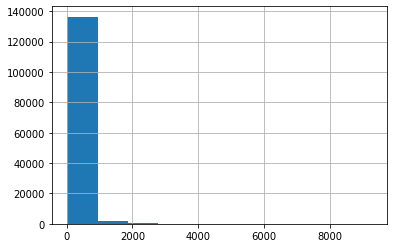

In [79]:
tmp['count'].hist()

## Популярный сценарий

In [48]:
df_short = df.limit(10)
df_short.checkpoint()

DataFrame[user_id: string, item_id: string, timestamp: timestamp, context: string, relevance: float]

In [38]:
popular_scenario = PopularScenario(spark)
popular_params_grid = {'alpha': (500, 1500), 'beta': (500, 1500)}
# popular_scenario.seed = 9876

In [32]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.2,
    k=100, context='no_context',
    to_filter_seen_items=True,
    n_trials=5, n_jobs=1,
    how_to_split='randomly'
)

11-Oct-19 15:16:45, root, DEBUG: Деление на трейн и тест
11-Oct-19 15:17:44, root, DEBUG: Размер трейна:      15999659
11-Oct-19 15:17:50, root, DEBUG: Размер теста_инпут: 15999659
11-Oct-19 15:18:04, root, DEBUG: Размер теста:       3999576
11-Oct-19 15:19:05, root, DEBUG: Медиана количества items у каждого user: 116.0
11-Oct-19 15:19:13, root, DEBUG: Начало оптимизации параметров
11-Oct-19 15:19:13, root, DEBUG: Предикт модели в оптимизации
11-Oct-19 15:19:13, root, DEBUG: Проверка датафреймов
11-Oct-19 15:20:11, root, DEBUG: Количество items после фильтрации: 216
11-Oct-19 15:20:50, root, DEBUG: Длина recs: 29876040
11-Oct-19 15:22:29, root, DEBUG: Подсчет метрики в оптимизации
11-Oct-19 15:26:15, root, DEBUG: Метрика и параметры: (0.06568340382460326, {'alpha': 417, 'beta': 439})
[I 2019-10-11 15:26:15,270] Finished trial#0 resulted in value: 0.06568340382460326. Current best value is 0.06568340382460326 with parameters: {'alpha': 417, 'beta': 439}.
11-Oct-19 15:26:15, root, DEBUG:

CPU times: user 595 ms, sys: 156 ms, total: 751 ms
Wall time: 35min 40s


In [33]:
best_params

{'alpha': 417, 'beta': 439}

In [40]:
results = popular_scenario.study.trials_dataframe()

results.head()

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.065683 2019-10-11 17:22:19.582548   
1  1      TrialState.COMPLETE  0.065683 2019-10-11 17:29:00.084536   
2  2      TrialState.COMPLETE  0.065683 2019-10-11 17:35:29.234527   
3  3      TrialState.COMPLETE  0.065683 2019-10-11 17:42:03.174263   
4  4      TrialState.COMPLETE  0.065683 2019-10-11 17:48:33.700309   

           datetime_complete params        user_attrs system_attrs  
                              alpha  beta some_metric      _number  
0 2019-10-11 17:29:00.083587  1072   1190  1.0         0            
1 2019-10-11 17:35:29.233421  1426   1301  1.0         1            
2 2019-10-11 17:42:03.173242  1205   539   1.0         2            
3 2019-10-11 17:48:33.698993  1412   1173  1.0         3            
4 2019-10-11 17:55:01.109490  1073   1345  1.0         4

In [ ]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты экспериента')

    plt.show()
    

plot_result_value(results)

In [41]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

10-Oct-19 12:38:45, root, DEBUG: Проверка датафреймов
10-Oct-19 12:38:54, root, DEBUG: Выделение дефолтных юзеров
10-Oct-19 12:38:54, root, DEBUG: Выделение дефолтных айтемов
10-Oct-19 12:39:12, root, DEBUG: Среднее количество items у каждого user: 145.0
10-Oct-19 12:39:25, root, DEBUG: Количество items после фильтрации: 155
10-Oct-19 12:39:45, root, DEBUG: Длина recs: 21466415


CPU times: user 47.3 ms, sys: 15.7 ms, total: 62.9 ms
Wall time: 2min 20s


In [42]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|    296| 100010|no_context|0.003388085821507815|
|    356| 100010|no_context|0.003331187738973...|
|    318| 100010|no_context|0.003190892466923...|
|    593| 100010|no_context|0.003187542579815...|
|    480| 100010|no_context|0.003008348618651...|
|    260| 100010|no_context|0.002747707402260...|
|    110| 100010|no_context|0.002711058637323922|
|    589| 100010|no_context|0.002634811206862329|
|   2571| 100010|no_context|0.002589312740160...|
|    527| 100010|no_context|0.002525314896887...|
+-------+-------+----------+--------------------+
only showing top 10 rows

